# 15-688 Final Project: IMDb Movie Reviews
<b>Team Members: Shengshan Xie (shengshx), Zirui Hua (ziruih) </b>
   
Customer reviews are of great value for business, and also for customers themselves. In this project, our team are going to explore machine learning with IMDb reviews for 1000 movies. Also, anyone on IMDb can see the number of "Helpful" votes and total number of votes (vote is either “Helpful" or not) that a given review has received, which is important reference for other users.

However, for reviews which receive almost no votes, especially for those movies few people have heard of. User experience can be improved if we can tell movie lovers the helpfulness of those reviews that hardly receive votes.

On the other hand, IMDb must wants to know what topics their users are interested in when talking about movies, that is, the topics hidden in reviews. Therefore, we would also try to discover some main topics in movie reviews, upon which IMDb can build their user strategy.


## Content
- [1. Dataset Loading and Preparing](# 1. Dataset Loading and Preparing)
- [2. Helpful Reviews Predicting](# 2. Helpful Reviews Predicting)
 - [2.1 Feature Constructing and Model Choosing](# 2.1 Feature Constructing and Model Choosing)
 - [2.2 Feature Engineering](# 2.2 Feature Engineering)
- [3. Exploring Topics in Reviews](# 3. Exploring Topics in Reviews)
 - [3.1 Topic Detection by LDA](# 3.1 Topic Detection by LDA)
 - [3.2 Visualizing Topics with Wordclouds](# 3.2 Visualizing Topics with Wordclouds)
 - [3.3 Clustering Reviews using Kmeans](# 3.3 Clustering Reviews using Kmeans)
- [4. Conclusion and Reference](# 4. Conclusion and Reference)

In [1]:
# Importing Libraries
import nltk, re, string, sklearn, gensim, requests, time, csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
from collections import Counter
from nltk.corpus import wordnet,stopwords
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.svm import LinearSVC
from scipy.spatial import distance
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from textblob import TextBlob
from wordcloud import WordCloud
from bs4 import BeautifulSoup


# 1. Dataset Loading and Preparing
## 1.1 Dataset Scrapping
For this project, we got reviews dataset from [IMDb](https://www.imdb.com/) reviews using web scraping technique we’ve learnt in this course. 

In [2]:
# Get IMDb user page data
def parse_user_page(user_url):
    url = "https://www.imdb.com" + user_url
    response = requests.get(url)
    if response.status_code != 200:
        return url
    try:
        htm = BeautifulSoup(response.text,'html.parser')
        user_id = htm.find('div',class_='user-profile userId')['data-userid']
        badge_cnt = len(htm.find_all('div',class_='badge-frame'))
        find_review = htm.find('a',href="/user/"+user_id+"/comments")
        if find_review:
            f = find_review.text
            review_cnt = int(f[f.find('all')+4:f.find('reviews')-1])
        else:
            review_cnt = len(htm.find_all('div',class_='toggle-overflow item'))
        return user_id, badge_cnt, review_cnt
    except:
        return url

In [3]:
# @para movie_url code of a movie ie. tt1677720
# return a list, including (author uri, content, helpful count, total count)
def parse_review_page(movie_url):
    url = "https://www.imdb.com/title/" + movie_url + "/reviews?sort=helpfulnessScore&dir=asc&ratingFilter=0"
    response = requests.get(url)
    if response.status_code != 200:
        return url
    try:
        html = BeautifulSoup(response.text, 'html.parser')
        comments = html.find_all('div', {'class': 'lister-item'})
        res = []
        for comment in comments:
            content = BeautifulSoup(str(comment), 'html.parser').find('div', {'class': 'text'}).text
            author_uri = BeautifulSoup(str(comment), 'html.parser').find('span', {'class': 'display-name-link'}).find('a')['href']
            counts = BeautifulSoup(str(comment), 'html.parser').find('div', {'class': 'actions text-muted'}).text
            count_list = [int(s) for s in counts.split() if s.isdigit()] # split content to find number
            res.append(tuple([author_uri, content, count_list[0], count_list[1]]))
        return res
    except:
        return url

In [4]:
# get data and save to local directory
idx = 0
for code in movie_code_list:
    idx += 1
    # get review
    review_list = parse_review_page(code)
    if (type(review_list) != list):
        continue
    result = []
    for review in review_list:
        user_uri, review, helpful_cnt, total = review
        # get user info
        try:
            user_id,badge_cnt,review_cnt = parse_user_page(user_uri)
        except ValueError:
            continue
        result.append(tuple([user_uri, review, badge_cnt, review_cnt, helpful_cnt, total, round(float(helpful_cnt/total), 3)]))
    with open('data.csv', 'a') as f:
        writer = csv.writer(f , lineterminator='\n')
        for row in result:
            writer.writerow(row)

## 1.2 Dataset Loading


In [2]:
# load original dataset got from IMDb
raw_data = pd.read_csv('data.csv',encoding="ISO-8859-1",header = None)

In [3]:
# set columns names
raw_data.columns = ['user_url','content','badge_cnt','review_cnt','helpful_cnt','total_vote','helpfulness']

In [4]:
raw_data.head()

,user_url,content,badge_cnt,review_cnt,helpful_cnt,total_vote,helpfulness
0,/user/ur14278480/?ref_=tt_urv,10. GOLD RUSH is based on an actual event.9. C...,7,414,0,8,0.0
1,/user/ur0270238/?ref_=tt_urv,"Although I've seen ""Raiders of the Lost Ark"" s...",3,157,0,55,0.0
2,/user/ur11749472/?ref_=tt_urv,"I've just finished watching ""Children of Heave...",2,9,0,13,0.0
3,/user/ur12725412/?ref_=tt_urv,Children of Heaven with director Majid Majidi ...,2,6,0,10,0.0
4,/user/ur20315296/?ref_=tt_urv,I'm currently a student at university and one ...,2,157,0,4,0.0


In [5]:
raw_data.describe()

,badge_cnt,review_cnt,helpful_cnt,total_vote,helpfulness
count,17574.000000,17574.000000,17574.000000,17574.000000,17574.000000
mean,3.312166,104.002788,39.520599,60.740696,0.324503
std,3.340018,200.896828,82.106288,109.556286,0.324777
min,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2.000000,2.000000,0.000000,1.000000,0.000000
50%,2.000000,10.000000,6.000000,17.000000,0.273000
75%,3.000000,87.000000,40.000000,71.000000,0.621000
max,46.000000,999.000000,834.000000,971.000000,1.000000


The dataset contains 17574 IMDb user reviews on randomly chosen 1000 movies. The dataset has columns: "user_url"(user page link of the reviewer), "content"(review content), "badge_cnt"(IMDb badge the user gained, and a badge means an achievement in IMDb), "review_cnt"(number of reviews a user has written), "helpful_cnt"(number of "helpful" votes for a review), "total_vote"(number of total votes for a review), "helpfulness"(helpful_cnt divided by total_vote).

As the above distribution shows, most reviews have few total votes, and several to zero helpful votes. One important thing is that we only use reviews which have at least one total vote, because otherwise the helpfulness cannot be calculated, and we can't use a review without any vote to train and predict.

Currently IMDb has provided options to display reviews by helpfulness or total votes, if we want to detect really helpful reviews which hidden by IMDb's filtering algorithm, we should set a high threshold of helpfulness. Therefore, we choose 70% as the threshold for helpful reviews.

## 1.2  Data Labeling
Label a review as helpful or not according to helpfulness value.

In [6]:
#  function to label 
def labeling(x):
    if x > 0.7: # helpfulness>0.7 is helpful
        return 1
    else: # otherwise unhelpful
        return -1

In [7]:
raw_data['label'] = raw_data['helpfulness'].apply(lambda x:labeling(x))

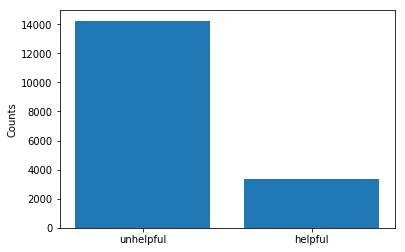

In [95]:
# plot the distribution of helpful and unhelpful reviews
y = list(Counter(raw_data.label).values())
x = ['unhelpful', 'helpful']
x_tick = np.arange(len(x))
plt.bar(x_tick, y)
plt.xticks(x_tick, x)
plt.ylabel('Counts')
plt.show()

With 70% as the threshold, the distribution of helpful and unhelpful is quite unbalanced. In real word, it's reasonable to assume that there are more reviews left unvoted and therefore treated as unhelpful than those voted as helpful. Training a model with such dataset will produce more practical value for real-world situation. However, we still plan to try undersampling and oversampling on the dataset to see if the performance will be better.

## 1.3 Text Processing
Basic text processing on review contents.

In [9]:
# Handle case and punctuation, and tokenize raw texts
def process(text, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    text = text.lower()
    text = re.sub('\'s','',text)
    text = re.sub('\'ve','',text)
    
    text_new = ''
    for i,c in enumerate(text):
        if c in string.punctuation:
            text_new = text_new + ' '
        else:
            text_new = text_new + c

    # tokenize and normalize
    tokens =nltk.word_tokenize(text_new)
    lem_lst = []
    for t in tokens:
        try:
            lem_lst.append(lemmatizer.lemmatize(t))
        except:
            continue
    return ' '.join(lem_lst)

# use process() to process a list of reviews
def process_all(df, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    df['content'] = df['content'].apply(lambda x:process(x))
    return df

In [10]:
processed_data = process_all(raw_data)
processed_data.to_csv('processed_data.csv',index = False)
processed_data.head()

,user_url,content,badge_cnt,review_cnt,helpful_cnt,total_vote,helpfulness,label
0,/user/ur14278480/?ref_=tt_urv,10 gold rush is based on an actual event 9 cit...,7,414,0,8,0.0,-1
1,/user/ur0270238/?ref_=tt_urv,although i seen raider of the lost ark several...,3,157,0,55,0.0,-1
2,/user/ur11749472/?ref_=tt_urv,i just finished watching child of heaven for t...,2,9,0,13,0.0,-1
3,/user/ur12725412/?ref_=tt_urv,child of heaven with director majid majidi is ...,2,6,0,10,0.0,-1
4,/user/ur20315296/?ref_=tt_urv,i m currently a student at university and one ...,2,157,0,4,0.0,-1


# 2. Helpful Reviews Predicting
This section will label each review as helpful(+1) or unhelpful(-1), and process original reviews for later sections.

## 2.1 Feature Constructing and Model Choosing

### (1) Feature Constructing
In this step, we remove rare and stop words, and construct original features.

In [13]:
# get words with frequency less than 1 in reviews.
def get_rare_words(reviews):
    reviews = reviews.values
    cnt = Counter()
    for review in reviews:
        cnt.update(Counter(review.split()))
    
    rare = []
    
    for k,v in cnt.items():
        if v < 2 :
            rare.append(k)
    return sorted(rare)

In [14]:
# remove stop words and rare words
rare_words = get_rare_words(processed_data.content)
stop_words = stopwords.words("english")
remove_list = rare_words + stop_words

processed2_data = processed_data.copy()
processed2_data['content'] = processed2_data['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in remove_list]))

In [15]:
processed2_data.to_csv('processed2_data.csv')
processed2_data.head()

,user_url,content,badge_cnt,review_cnt,helpful_cnt,total_vote,helpfulness,label
0,/user/ur14278480/?ref_=tt_urv,10 gold rush based actual event 9 city light m...,7,414,0,8,0.0,-1
1,/user/ur0270238/?ref_=tt_urv,although seen raider lost ark several time boy...,3,157,0,55,0.0,-1
2,/user/ur11749472/?ref_=tt_urv,finished watching child heaven first time fact...,2,9,0,13,0.0,-1
3,/user/ur12725412/?ref_=tt_urv,child heaven director majid majidi movie excel...,2,6,0,10,0.0,-1
4,/user/ur20315296/?ref_=tt_urv,currently student university one studying intr...,2,157,0,4,0.0,-1


In [16]:
# split dataset into training and test set
X = processed2_data.content
y = processed2_data.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Construct original features
vectorizer = CountVectorizer()
features_train = vectorizer.fit_transform(X_train)
features_test = vectorizer.transform(X_test)
print('training set shape: ',features_train.shape)
print('test set shape: ',features_test.shape)

training set shape:  (14059, 35361)
test set shape:  (3515, 35361)


### (2) Model Choosing
Naive Bayes and Linear Support Vector Machine are widely-used binary classifiers for tasks like ours, so we choose Multinomical NB and Linear SVM from sklearn. Because simple NB assumes token frequncy as continuous value, which is not, we decide to use Multinomial NB. As for SVM, linear kernel makes it faster than non-linear.

We will train the 2 models, and then try with undersampling and oversampling training, considering the unbalanced number of 2 classes. We will report the 5-fold cross validation average accuracy and test set confusion matrix for each training, so as to decide on the best model to continue our classification task.

In [19]:
def train(model,train_features,train_y,test_features,test_y):
    model.fit(train_features, train_y)
    predict = model.predict(test_features)
    # cross validation average accuracy
    score = cross_val_score(model, train_features,  train_y, cv=5, scoring='accuracy').mean() 
    print('accuracy of',model, 'is: ',score)
    # test set performance: confusion matrix
    print(metrics.classification_report(test_y, predict))

In [20]:
train(MultinomialNB(),features_train,y_train,features_test,y_test)

accuracy of MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) is:  0.8020482227721752
             precision    recall  f1-score   support

         -1       0.88      0.87      0.87      2824
          1       0.49      0.51      0.50       691

avg / total       0.80      0.80      0.80      3515



In [21]:
train(LinearSVC(random_state=42),features_train,y_train,features_test,y_test)

accuracy of LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0) is:  0.8191901881580197
             precision    recall  f1-score   support

         -1       0.88      0.90      0.89      2824
          1       0.56      0.51      0.53       691

avg / total       0.82      0.82      0.82      3515



### undersampling


In [22]:
def under(model,train_features,train_y,test_features,test_y):
    # under sampling
    rs = RandomUnderSampler(return_indices=True)
    X_train_resampled, y_train_resampled, idx_resampled = rs.fit_sample(train_features, train_y)
    
    model.fit(X_train_resampled, y_train_resampled)
    predict = model.predict(test_features)
    score = cross_val_score(model, X_train_resampled,  y_train_resampled, cv=5, scoring='accuracy').mean()
    print('accuracy of',model, 'is: ',score)
    print(metrics.classification_report(test_y, predict))
    

In [23]:
under(MultinomialNB(),features_train,y_train,features_test,y_test)

accuracy of MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) is:  0.7151715644154207
             precision    recall  f1-score   support

         -1       0.92      0.69      0.79      2824
          1       0.37      0.75      0.50       691

avg / total       0.81      0.70      0.73      3515



In [24]:
under(LinearSVC(random_state=42),features_train,y_train,features_test,y_test)

accuracy of LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0) is:  0.7079907057340895
             precision    recall  f1-score   support

         -1       0.91      0.73      0.81      2824
          1       0.38      0.69      0.49       691

avg / total       0.80      0.72      0.74      3515



### oversampling

In [25]:
def over(model,train_features,train_y,test_features,test_y):
    # over sampling
    rs = RandomOverSampler(random_state=50)
    X_train_resampled, y_train_resampled = rs.fit_sample(train_features, train_y)
    
    model.fit(X_train_resampled, y_train_resampled)
    predict = model.predict(test_features)
    score = cross_val_score(model, X_train_resampled,  y_train_resampled, cv=5, scoring='accuracy').mean()
    print('accuracy of',model, 'is: ',score)
    print(metrics.classification_report(test_y, predict))

In [26]:
over(MultinomialNB(),features_train,y_train,features_test,y_test)

accuracy of MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) is:  0.8242535055036349
             precision    recall  f1-score   support

         -1       0.89      0.82      0.86      2824
          1       0.45      0.60      0.51       691

avg / total       0.81      0.78      0.79      3515



In [27]:
over(LinearSVC(random_state=42),features_train,y_train,features_test,y_test)

accuracy of LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0) is:  0.9389075041059595
             precision    recall  f1-score   support

         -1       0.88      0.90      0.89      2824
          1       0.55      0.51      0.53       691

avg / total       0.82      0.82      0.82      3515



The classification task is to detect helpful reviews as accurately as possible, so we prefer the model with higher precision (TP/(TP+FP)). Because currently there's no big difference in result between train() and over(), and between NB and SVM, the following steps will train on 4 models: train(NB),train(SVM),over(NB),and over(SVM).

## 2.2 Feature Engineering
Based on original features, we will try to create new features to improve performance, and choose the model with highest final performance.

### (1) N-Gram

In [28]:
#produce trigram tf_idf matrix
n_vectorizer = TfidfVectorizer(min_df=0.01,max_df=0.5,ngram_range=(2,3))
n_tfidf= n_vectorizer.fit_transform(processed2_data.content)
#generate a trigram vocabulary
gram_lst = n_vectorizer.get_feature_names()

In [29]:
X1 = processed2_data.content
y1 = processed2_data.label
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [30]:
features1_train = vectorizer.fit_transform(X1_train)
features1_test = vectorizer.transform(X1_test)
print('training set shape: ',features1_train.shape)
print('test set shape: ',features1_test.shape)

training set shape:  (14059, 35361)
test set shape:  (3515, 35361)


In [31]:
# convert ngram feature sparse matrix to dense matrix
features1_ngram_train = n_vectorizer.fit_transform(X1_train).todense()
features1_ngram_test = n_vectorizer.transform(X1_test).todense()

In [32]:
# convert original feature sparse matrix to dense matrix
features1_train_dense = features1_train.todense()
features1_test_dense = features1_test.todense()

# append ngram to original features
features1_train = sp.csr_matrix(np.concatenate((features1_train_dense, features1_ngram_train),axis=1))
features1_test = sp.csr_matrix(np.concatenate((features1_test_dense, features1_ngram_test),axis=1))

print('training set shape: ',features1_train.shape)
print('test set shape: ',features1_test.shape)

training set shape:  (14059, 35630)
test set shape:  (3515, 35630)


In [33]:
train(MultinomialNB(),features1_train,y1_train,features1_test,y1_test)

accuracy of MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) is:  0.8021906220585094
             precision    recall  f1-score   support

         -1       0.88      0.86      0.87      2824
          1       0.48      0.52      0.50       691

avg / total       0.80      0.79      0.80      3515



In [34]:
train(LinearSVC(random_state=42),features1_train,y1_train,features1_test,y1_test)

accuracy of LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0) is:  0.8169858826156903
             precision    recall  f1-score   support

         -1       0.88      0.90      0.89      2824
          1       0.55      0.50      0.52       691

avg / total       0.81      0.82      0.82      3515



In [35]:
over(MultinomialNB(),features1_train,y1_train,features1_test,y1_test)

accuracy of MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) is:  0.8216260174763136
             precision    recall  f1-score   support

         -1       0.89      0.82      0.86      2824
          1       0.45      0.59      0.51       691

avg / total       0.80      0.78      0.79      3515



In [36]:
over(LinearSVC(random_state=42),features1_train,y1_train,features1_test,y1_test)

accuracy of LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0) is:  0.9386886858091443
             precision    recall  f1-score   support

         -1       0.88      0.90      0.89      2824
          1       0.54      0.50      0.52       691

avg / total       0.81      0.82      0.82      3515



<b>The precision drops a little, so n-gram does not help to improve.

### (2) Sentiment Score

In [37]:
# calculate sentiment polarity values
def senti_score(text):
    return TextBlob(text).sentences[0].sentiment.polarity

In [39]:
processed3_data = processed2_data.copy()
processed3_data['sent_score'] = processed3_data['content'].apply(lambda x: np.exp(senti_score(x))*10)

In [41]:
X2 = processed3_data.content
y2 = processed3_data.label
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [42]:
train2_idx = X2_train.index
test2_idx = X2_test.index
train2_score = processed4_data.iloc[train2_idx]['sent_score']
test2_score = processed4_data.iloc[test2_idx]['sent_score']

# reset index according to random spliting
train2_score.reset_index(inplace = True, drop = True)
test2_score.reset_index(inplace = True, drop = True)

In [43]:
features2_train = vectorizer.fit_transform(X2_train)
features2_test = vectorizer.transform(X2_test)
print('training set shape: ',features2_train.shape)
print('test set shape: ',features2_test.shape)

training set shape:  (14059, 35361)
test set shape:  (3515, 35361)


In [44]:
features2_train_dense = features2_train.todense()
features2_test_dense = features2_test.todense()

features2_train_lst = []
features2_test_lst = []

# append sentiment values to original features
for i in range(features2_train.shape[0]):
    features2_train_lst.append(np.append(np.array(features2_train_dense[i])[0],train2_score[i]))

for i in range(features2_test.shape[0]):
    features2_test_lst.append(np.append(np.array(features2_test_dense[i])[0], test2_score[i]))
    
features2_train = sp.csr_matrix(np.array(features2_train_lst))
features2_test = sp.csr_matrix(np.array(features2_test_lst))


print('training set shape: ',features2_train.shape)
print('test set shape: ',features2_test.shape)

training set shape:  (14059, 35362)
test set shape:  (3515, 35362)


In [46]:
train(MultinomialNB(),features2_train,y2_train,features2_test,y2_test)

accuracy of MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) is:  0.8130737973551925
             precision    recall  f1-score   support

         -1       0.88      0.89      0.88      2824
          1       0.52      0.48      0.50       691

avg / total       0.80      0.81      0.81      3515



In [47]:
train(LinearSVC(random_state=42),features2_train,y2_train,features2_test,y2_test)

accuracy of LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0) is:  0.818905338999459
             precision    recall  f1-score   support

         -1       0.88      0.90      0.89      2824
          1       0.56      0.51      0.53       691

avg / total       0.82      0.82      0.82      3515



In [45]:
over(MultinomialNB(),features2_train,y2_train,features2_test,y2_test)

accuracy of MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) is:  0.8258303972175364
             precision    recall  f1-score   support

         -1       0.89      0.87      0.88      2824
          1       0.50      0.56      0.53       691

avg / total       0.81      0.80      0.81      3515



In [48]:
over(LinearSVC(random_state=42),features2_train,y2_train,features2_test,y2_test)

accuracy of LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0) is:  0.9383818991050121
             precision    recall  f1-score   support

         -1       0.88      0.90      0.89      2824
          1       0.56      0.51      0.53       691

avg / total       0.82      0.82      0.82      3515



<b>All models improve a little in precision except train(SVM), so sentiment score can be helpful.

### (3) Part of Speech Tagging

In [49]:
processed4_data = processed2_data.copy()
processed4_data.reset_index(inplace = True, drop = True)

In [50]:
# join helpful(unhelpful) reviews as a string
content_helpful = ' '.join(processed4_data[processed4_data['label']==1]['content'].values).split()
content_unhelpful = ' '.join(processed4_data[processed4_data['label']== -1]['content'].values).split()

In [51]:
# get POS tag for each word
tag_helpful = nltk.pos_tag(content_helpful)
tag_unhelpful = nltk.pos_tag(content_unhelpful)

In [52]:
# create a dictionary of word: tag
def create_tag_dict(taglist):
    dict = {}
    for i in range(len(taglist)):
        key = taglist[i][1]
        if key in dict.keys():
            dict[key] += 1
        else:
            dict[key] = 1
    return dict

In [53]:
helpful_dict = create_tag_dict(tag_helpful) 
unhelpful_dict = create_tag_dict(tag_unhelpful)

In [54]:
# create a list to keep frequency of each tag
def create_freq_lst(tag_dict, total_num):
    freq_lst = []
    for k in tag_dict.keys():
        freq_lst.append(tag_dict[k]/total_num)
    return freq_lst 

In [55]:
helpful_freq = create_freq_lst(helpful_dict, len(tag_helpful))
unhelpful_freq = create_freq_lst(unhelpful_dict, len(tag_unhelpful))

In [56]:
X3 = processed4_data.content
y3 = processed4_data.label
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)

In [57]:
# get set of all tags
tag_list = list(set(helpful_dict.keys()).union(unhelpful_dict.keys()))

In [58]:
# a dictionary mapping tag and its index in tag_list
tag_idx = {t:i for i,t in enumerate(tag_list)}

In [59]:
# create tag feature for a review
def create_tag_feature(text, tag_list, tag_idx):
    # a list representing tag features. 0 means no such tag, 1 means all words have the same tag.
    feature_list = np.zeros(len(tag_list))
    # get tags for each word
    tags = nltk.pos_tag(text.split())
    l = len(tags)
    # count frequency of tags
    tag_cnt = Counter([t[1] for t  in tags])
    # fill in with tag frequency
    for k,v in tag_cnt.items():
        feature_list[tag_idx[k]]=v/l
    return feature_list

In [60]:
features3_train = vectorizer.fit_transform(X3_train)
features3_test = vectorizer.transform(X3_test)
print('training set shape: ',features3_train.shape)
print('test set shape: ',features3_test.shape)

training set shape:  (14059, 35361)
test set shape:  (3515, 35361)


In [61]:
features3_train_dense = features3_train.todense()
features3_test_dense = features3_test.todense()

features3_train_tag = np.array(X3_train.apply(lambda x:create_tag_feature(x,tag_list, tag_idx)).tolist())
features3_test_tag = np.array(X3_test.apply(lambda x:create_tag_feature(x,tag_list, tag_idx)).tolist())

features3_train = sp.csr_matrix(np.concatenate((features3_train_dense, features3_train_tag),axis=1))
features3_test = sp.csr_matrix(np.concatenate((features3_test_dense, features3_test_tag),axis=1))


print('training set shape: ',features3_train.shape)
print('test set shape: ',features3_test.shape)

training set shape:  (14059, 35399)
test set shape:  (3515, 35399)


In [62]:
train(MultinomialNB(),features3_train,y3_train,features3_test,y3_test)

accuracy of MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) is:  0.80404004227463
             precision    recall  f1-score   support

         -1       0.88      0.87      0.87      2824
          1       0.49      0.51      0.50       691

avg / total       0.80      0.80      0.80      3515



In [63]:
train(LinearSVC(random_state=42),features3_train,y3_train,features3_test,y3_test)

accuracy of LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0) is:  0.8194743796999827
             precision    recall  f1-score   support

         -1       0.88      0.90      0.89      2824
          1       0.56      0.51      0.53       691

avg / total       0.82      0.82      0.82      3515



In [64]:
over(MultinomialNB(),features3_train,y3_train,features3_test,y3_test)

accuracy of MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) is:  0.82565469053608
             precision    recall  f1-score   support

         -1       0.89      0.83      0.86      2824
          1       0.46      0.59      0.52       691

avg / total       0.81      0.78      0.79      3515



In [65]:
over(LinearSVC(random_state=42),features3_train,y3_train,features3_test,y3_test)

accuracy of LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0) is:  0.9388637020910668
             precision    recall  f1-score   support

         -1       0.88      0.90      0.89      2824
          1       0.55      0.51      0.53       691

avg / total       0.82      0.82      0.82      3515



<b>POS tagging only improves precision of over(NB) by 1%

### (4) User information - badge count

In [66]:
X4 = processed2_data.content
y4 = processed2_data.label
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=42)

In [67]:
# get badge_cnt for train and test sets.
badge_train = processed2_data.badge_cnt.values[X4_train.index.values]
badge_test = processed2_data.badge_cnt.values[X4_test.index.values]

In [68]:
features4_train = vectorizer.fit_transform(X4_train)
features4_test = vectorizer.transform(X4_test)
print('training set shape: ',features4_train.shape)
print('test set shape: ',features4_test.shape)

training set shape:  (14059, 35361)
test set shape:  (3515, 35361)


In [69]:
features4_train_dense = features4_train.todense()
features4_test_dense = features4_test.todense()

features4_train = sp.csr_matrix(np.concatenate((features4_train_dense, np.matrix(badge_train).T),axis=1))
features4_test = sp.csr_matrix(np.concatenate((features4_test_dense, np.matrix(badge_test).T),axis=1))

print('training set shape: ',features4_train.shape)
print('test set shape: ',features4_test.shape)

training set shape:  (14059, 35362)
test set shape:  (3515, 35362)


In [70]:
train(MultinomialNB(),features4_train,y4_train,features4_test,y4_test)

accuracy of MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) is:  0.8072408898918386
             precision    recall  f1-score   support

         -1       0.88      0.88      0.88      2824
          1       0.50      0.50      0.50       691

avg / total       0.80      0.80      0.80      3515



In [71]:
train(LinearSVC(random_state=42),features4_train,y4_train,features4_test,y4_test)

accuracy of LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0) is:  0.8201148223872418
             precision    recall  f1-score   support

         -1       0.88      0.90      0.89      2824
          1       0.56      0.51      0.54       691

avg / total       0.82      0.83      0.82      3515



In [72]:
over(MultinomialNB(),features4_train,y4_train,features4_test,y4_test)

accuracy of MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) is:  0.8284139298078464
             precision    recall  f1-score   support

         -1       0.89      0.84      0.86      2824
          1       0.47      0.58      0.52       691

avg / total       0.81      0.79      0.80      3515



In [73]:
over(LinearSVC(random_state=42),features4_train,y4_train,features4_test,y4_test)

accuracy of LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0) is:  0.9388637788021261
             precision    recall  f1-score   support

         -1       0.88      0.90      0.89      2824
          1       0.56      0.51      0.53       691

avg / total       0.82      0.82      0.82      3515



<b> Badge_cnt improves precisions of train(NB), over(NB), and over(SVM).

### (5) User information - user historical reviews count

In [74]:
# get review_cnt for train and test sets.
reviewed_train = processed2_data.review_cnt.values[X4_train.index.values]
reviewed_test = processed2_data.review_cnt.values[X4_test.index.values]

In [75]:
features4_train = sp.csr_matrix(np.concatenate((features4_train_dense, np.matrix(reviewed_train).T),axis=1))
features4_test = sp.csr_matrix(np.concatenate((features4_test_dense, np.matrix(reviewed_test).T),axis=1))

print('training set shape: ',features4_train.shape)
print('test set shape: ',features4_test.shape)

training set shape:  (14059, 35362)
test set shape:  (3515, 35362)


In [76]:
train(MultinomialNB(),features4_train,y4_train,features4_test,y4_test)

accuracy of MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) is:  0.7909510438588537
             precision    recall  f1-score   support

         -1       0.88      0.85      0.87      2824
          1       0.47      0.53      0.50       691

avg / total       0.80      0.79      0.79      3515



In [77]:
train(LinearSVC(random_state=42),features4_train,y4_train,features4_test,y4_test)

accuracy of LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0) is:  0.814781678245145
             precision    recall  f1-score   support

         -1       0.87      0.90      0.89      2824
          1       0.54      0.46      0.50       691

avg / total       0.81      0.82      0.81      3515



In [78]:
over(MultinomialNB(),features4_train,y4_train,features4_test,y4_test)

accuracy of MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) is:  0.8213622464987156
             precision    recall  f1-score   support

         -1       0.89      0.82      0.86      2824
          1       0.45      0.60      0.51       691

avg / total       0.81      0.78      0.79      3515



In [79]:
over(LinearSVC(random_state=42),features4_train,y4_train,features4_test,y4_test)

accuracy of LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0) is:  0.9022493216824576
             precision    recall  f1-score   support

         -1       0.89      0.81      0.85      2824
          1       0.43      0.58      0.49       691

avg / total       0.80      0.77      0.78      3515



<b> Apparently review_cnt doest not help to improve precision.

### (6) Number of words in a  review


In [92]:
X5 = processed2_data.content
y5 = processed2_data.label
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=0.2, random_state=42)

In [81]:
# get number of words for each review
X5_train_len = X5_train.apply(len)
X5_test_len = X5_test.apply(len)

In [82]:
X5_train_len.reset_index(inplace = True, drop = True)
X5_test_len.reset_index(inplace = True, drop = True)

In [83]:
features5_train = vectorizer.fit_transform(X5_train)
features5_test = vectorizer.transform(X5_test)
print('training set shape: ',features5_train.shape)
print('test set shape: ',features5_test.shape)

training set shape:  (14059, 35361)
test set shape:  (3515, 35361)


In [84]:
features5_train_dense = features5_train.todense()
features5_test_dense = features5_test.todense()

features5_train_lst = []
features5_test_lst = []

for i in range(features5_train.shape[0]):
    features5_train_lst.append(np.append(np.array(features5_train_dense[i])[0],X5_train_len[i]))

for i in range(features5_test.shape[0]):
    features5_test_lst.append(np.append(np.array(features5_test_dense[i])[0], X5_test_len[i]))
    
features5_train = sp.csr_matrix(np.array(features5_train_lst))
features5_test = sp.csr_matrix(np.array(features5_test_lst))


print('training set shape: ',features5_train.shape)
print('test set shape: ',features5_test.shape)

training set shape:  (14059, 35362)
test set shape:  (3515, 35362)


In [85]:
train(MultinomialNB(),features5_train,y5_train,features5_test,y5_test)

accuracy of MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) is:  0.8048934768606852
             precision    recall  f1-score   support

         -1       0.88      0.87      0.87      2824
          1       0.49      0.50      0.50       691

avg / total       0.80      0.80      0.80      3515



In [86]:
train(LinearSVC(random_state=42),features5_train,y5_train,features5_test,y5_test)

accuracy of LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0) is:  0.7854650797366448
             precision    recall  f1-score   support

         -1       0.81      1.00      0.89      2824
          1       0.81      0.06      0.11       691

avg / total       0.81      0.81      0.74      3515



In [87]:
over(MultinomialNB(),features5_train,y5_train,features5_test,y5_test)

accuracy of MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) is:  0.8233336823686536
             precision    recall  f1-score   support

         -1       0.89      0.82      0.86      2824
          1       0.45      0.59      0.51       691

avg / total       0.81      0.78      0.79      3515



In [88]:
over(LinearSVC(random_state=42),features5_train,y5_train,features5_test,y5_test)

accuracy of LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0) is:  0.7534447292981781
             precision    recall  f1-score   support

         -1       0.96      0.45      0.61      2824
          1       0.29      0.92      0.44       691

avg / total       0.83      0.54      0.58      3515



<b> Number of words feature helps to improve the precision of train(SVM) from 56% to 81%.

### Concluding Part 2
The train(SVM) model with number of words feature reaches to the highest precision (81%), and its overall performance is also good. It's reasonable to suppose that if a review is long, the reviewer must have put his heart on writing it. Given the poor performance before feature engineering, it seems that sometimes a simple feature inspired by common sense can make a big difference.

# 3. Exploring Topics in Reviews


## 3.1 Topic Detection by LDA


In [2]:
lda_data = pd.read_csv("processed2_data.csv",usecols = [2])
lda_data.head()

,content
0,10 gold rush based actual event 9 city light m...
1,although seen raider lost ark several time boy...
2,finished watching child heaven first time fact...
3,child heaven director majid majidi movie excel...
4,currently student university one studying intr...


In [3]:
tokens = lda_data.content.apply(lambda x: x.split())
tokens_dict = gensim.corpora.Dictionary(tokens)
corpus = [tokens_dict.doc2bow(t) for t in tokens]

len(corpus)

17574

In [4]:
k = [2,3,4,5,6,7,8,9,10,15,20,30]
plb = np.zeros(len(k))
model_lst = []

for i,v in enumerate(k):
    model = gensim.models.ldamodel.LdaModel(corpus, num_topics=v, id2word = tokens_dict, passes=10)
    model_lst.append(model)
    plb[i]= model.log_perplexity(corpus)
    model.save('lda_'+str(v))
print(plb)

[-8.15251935 -8.14105025 -8.13239153 -8.1283992  -8.13372317 -8.13647646
 -8.13878608 -8.13857592 -8.14579629 -8.15032748 -8.16446513 -8.19158715]


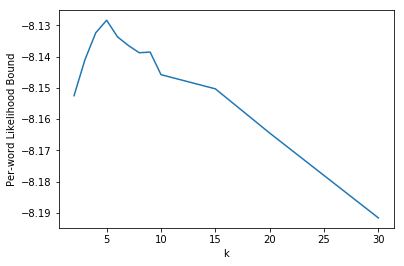

When k =  2 , per-word likelihood bound is  -8.15251935 , and perplexity extimation is  284.546248763311
When k =  3 , per-word likelihood bound is  -8.14105025 , and perplexity extimation is  282.29313802671714
When k =  4 , per-word likelihood bound is  -8.13239153 , and perplexity extimation is  280.6039544004015
When k =  5 , per-word likelihood bound is  -8.1283992 , and perplexity extimation is  279.82852026832046
When k =  6 , per-word likelihood bound is  -8.13372317 , and perplexity extimation is  280.86307773707426
When k =  7 , per-word likelihood bound is  -8.13647646 , and perplexity extimation is  281.39959851595336
When k =  8 , per-word likelihood bound is  -8.13878608 , and perplexity extimation is  281.850453780259
When k =  9 , per-word likelihood bound is  -8.13857592 , and perplexity extimation is  281.8093991044213
When k =  10 , per-word likelihood bound is  -8.14579629 , and perplexity extimation is  283.2233281474748
When k =  15 , per-word likelihood bound is 

In [5]:
plt.plot(k,plb)
plt.xlabel('k')
plt.ylabel('Per-word Likelihood Bound')
plt.show()

for i,p in enumerate(plb):
    perplexity = 2**(-p)
    print("When k = ",k[i],", per-word likelihood bound is ", p, ", and perplexity extimation is ",perplexity)

When K =5, per-word likelihood bound is apparently the highest, and the estimated perplexity reaches the lowest, so it suggests that there are about 5 topics in user reviews. 

And now let's first see the top 10 words for each topics the LDA model found.

In [6]:
k = 5
lda = gensim.models.LdaModel.load('lda_5')

In [7]:
for i in range(k):
    # display 10 words per topic
    print("top 10 words and their frequency in topic #",i+1,"\n",lda.show_topic(i,10))

top 10 words and their frequency in topic # 1 
 [('movie', 0.048998337), ('wa', 0.03274194), ('like', 0.012887651), ('one', 0.010637589), ('film', 0.010084991), ('time', 0.009322072), ('good', 0.008738782), ('really', 0.008234499), ('people', 0.007855088), ('would', 0.007249041)]
top 10 words and their frequency in topic # 2 
 [('movie', 0.014436508), ('film', 0.009366658), ('ha', 0.009309526), ('story', 0.007547394), ('one', 0.0074585415), ('love', 0.0063921977), ('character', 0.0049792505), ('well', 0.004516004), ('best', 0.004505815), ('life', 0.0043980936)]
top 10 words and their frequency in topic # 3 
 [('man', 0.005413873), ('one', 0.005079922), ('wa', 0.0049757604), ('life', 0.0049639824), ('ha', 0.0049580345), ('war', 0.0037306126), ('film', 0.003425819), ('woman', 0.0028650423), ('two', 0.002675106), ('world', 0.0024506093)]
top 10 words and their frequency in topic # 4 
 [('film', 0.04465284), ('one', 0.010273067), ('character', 0.009392416), ('story', 0.008606935), ('wa', 0

## 3.2 Visualizing Topics with Wordclouds
Here we plot the top 50 words with wordclouds for a better visualization.

In [8]:
def get_top_words(model,topic_id, top_number):
    return model.show_topic(topic_id, top_number)

def drawCloud(n_topics):
    # for each topic
    for i in range(n_topics):
        # draw the wordcloud
        cloud = WordCloud(background_color="white", stopwords=stopwords,max_font_size=60).fit_words(frequencies=dict(get_top_words(lda,i,100)))
        print("Topic "+ str(i+1))
        plt.imshow(cloud,interpolation='bilinear')
        plt.axis("off")
        plt.title('Topic '+str(i+1))
        plt.show()
        plt.close()
    

Topic 1


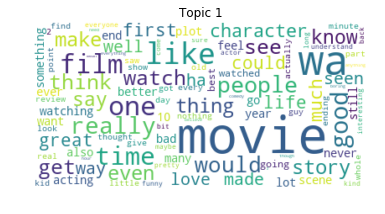

Topic 2


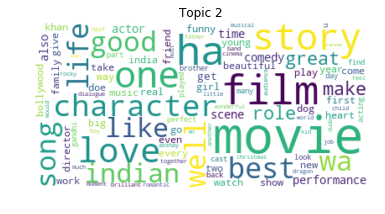

Topic 3


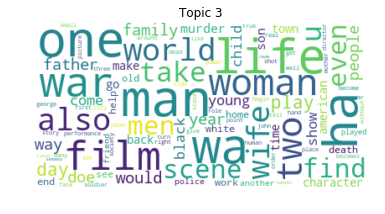

Topic 4


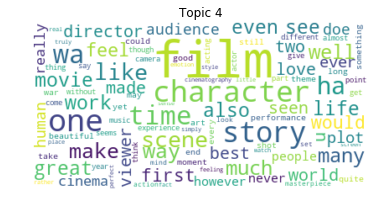

Topic 5


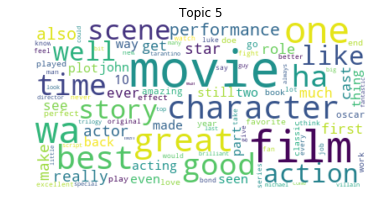

In [9]:
drawCloud(5)

The word clouds display 5 clusters provided by LDA model. The size of a word represents the frequency of this word in this topic. We analyze the topic of each cluster:
- Topic 1: Movie Experience
- Topic 2: Indian Movie
- Topic 3: Role Relationship
- Topic 4: Cast, Director and Producer
- Topic 5: Actor/Actress Performaning

## 3.3 Clustering Reviews using Kmeans


In this part, we will implement clustering algorithms to perform topic detection, to find out the topic that a certain review talked about

Step 1: Obtain the topic distribution probability per review

In [10]:
distances = list(lda.get_document_topics(corpus))
# initialize a len(corpus)*5 matrix to store the distance between record and each cluster center
doc_topic_dist = np.zeros((len(corpus),5))
# for each distance
for i,d in enumerate(distances):
    for t in d:
        ind = t[0]
        dist = t[1]
        doc_topic_dist[i,ind]=dist
print(np.sum(doc_topic_dist,axis=1)) 

[0.9931792  0.98579666 0.99931846 ... 0.99881686 0.99696947 0.99362147]


Step 2: Cluster reviews into 5 topics according to the  distribution probability

In [11]:
C=5 # assign number of cluster to 5
# train the kmeans model
kmeans = KMeans(n_clusters=C, random_state=321).fit(doc_topic_dist)
centers = kmeans.cluster_centers_ 
print(centers)

[[0.20637611 0.53436842 0.08326224 0.12392304 0.0480321 ]
 [0.19879829 0.04652941 0.50603351 0.16848015 0.07721487]
 [0.6806505  0.04987124 0.07279697 0.11080508 0.07938723]
 [0.17965165 0.04345639 0.11435369 0.59569581 0.06247399]
 [0.1643843  0.02934884 0.09966503 0.12557653 0.57615116]]


In [12]:
# read in raw review text
review_original = pd.read_csv('processed_data.csv', usecols=[1])

In [14]:
for c in range(5):
    min_dist = np.inf
    min_idx = 0;
    for i in range(len(corpus)):
        # get distance between topic and current record
        dist = distance.euclidean(centers[c],doc_topic_dist[i])
        if dist < min_dist:
            # reassign the cluster
            min_dist = dist
            min_idx = i
    row = tuple(review_original.iloc[min_idx].tolist())
    print('Cluster #',c+1,"\n",row)

Cluster # 1 
 ('i m a sucker for movie about musician and john carney ha already given u once 2007 and begin again 2013 now he delight once more with sing street a tale told with humor drama and some pretty catchy song all set in the backdrop of 1980 dublin yes sing street is set in the 80 so it undeniably lends itself to comic relief a these schoolboy are forced to navigate through hair makeup clothing and music video choice along their artistic journey we get plenty of laugh a we watch them try to forge an identity and look like bona fide rock star in this crazy mtv generation and for good measure they insert the obligatory phil collins joke in the mix there is quite a deal of drama a well we see bullying in an all boy school dysfunctional family the economic hardship of ireland in the 80 and young people wish to break out of societal malaise and seek their fortune elsewhere i haven t lived in ireland but the desire to pack your bag and start over in another place is a universal one 

## Concluding Topic Detection
- Topic 1: Movie Experience - cluster 4
- Topic 2: Indian Movie - cluster 2
- Topic 3: Role Relationship - cluster 1
- Topic 4: Cast, Director and Producer - cluster 5
- Topic 5: Actor/Actress Performaning - cluster 3

In this part we implemented two unsupervised learning algorithms to cluster text. From the above summry, we find that the results of LDA and Kmeans matched two out of five. LDA assigns a document to a group of topics. Therefore each document is characterized by one or more topics. Hence, the result of LDA is more infromative and realistic than K-means to assgin topic

# 4. Conclusion and Reference

In the first Machine Learning task, we trained a Linear SVM model, and use the number of words as new features to achieve a satisfactory positive precision. IMDb can use this simple feature to identify helpful reviews which few people voted as "helpful", in order to improve the user experience.

Secondly, we found 5 topics in movie reviews, which shows what movie lovers talk when they talk about movies. IMDb can use this information to get to know their users and even the movies better.

For future work, we can try more machine learning algorithms, and discover new features. Especially the feature engineering part. Also, it would be interesting to see if our model can be used for other dataset, such as book reviews, and game reviews etc. Finally, we think if we start with topic detection first, and use the clustering result as features for the binary classification, the model may be better.

Here are reference and future resources:

- IMDb Website
(www.imdb.com)

- PySpark and LDA
(https://sean.lane.sh/blog/2016/PySpark_and_LDA)

- Automated Text Binary Classification Using Machine Learning Approach
(https://www.researchgate.net/publication/220039796_Automated_Text_Binary_Classification_Using_Machine_Learning_Approach)

- Language Modeling
(https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)